In [22]:
import glob
import random

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch import Tensor, tensor

In [35]:
from thulac import thulac
thu = thulac(seg_only=True)

class MyDataset():
        
    def __init__(self):
        self.category_lines = {1: [], 2: [], 3: [], 4: []}
        # 验证集
        self.category_lines_vali = {1: [], 2: [], 3: [], 4: []}
        # 测试集
        self.category_lines_test = {1: [], 2: [], 3: [], 4: []}
        
        self.word_vec = self.load_word_vector()
        self.vector_dim = 300
        
    def load_word_vector(self, in_name='data/sgns.financial.word'):
        """
        加载ACL2018词向量
        """
        word_vec = {}
        print('加载词向量中 ...')
        for i, line in enumerate(open(in_name)):
            if i <= 1:
                continue
            if i > 250000:
                break
            words = line.strip().split(' ')
            word = words[0]
#             print(word)
            word_vec[word] = np.array([float(num) for num in words[1:]])
    #         except UnicodeDecodeError:
    #             print("编码问题，行 {}".format(i))
        print('加载词完成！一共 {}个词'.format(len(word_vec)))
        return word_vec

    def load(self):
        """
        加载原始文本
        """
        print('加载原始文本中 ...')
        for in_name in glob.glob('data/labelled_split/*.txt'):
            for i, line in enumerate(open(in_name)):
                if line.strip() == '':
                    continue
                label = line.split('\t')[0]
                # 1234：四种情绪，-：没有情绪，x：不确定
                if label in ['1', '2', '3', '4']:
                    if label == '-' or label == 'x':
                        y = int('0')
                    else:
                        y = int(label)
                self.category_lines[y].append(line.split('\t')[1].strip())
    
    def flow_to_vali_test(self):
        """
        训练数据流部分数据到验证集和测试集，分别为80%，10%，10%
        """
        random.seed(41)
        for i in range(1, 5):
            random.shuffle(self.category_lines[i])
            _len = len(self.category_lines[i])
            tenth = int(_len / 10)
            self.category_lines_vali[i] = self.category_lines[i][0: tenth]
            self.category_lines_test[i] = self.category_lines[i][tenth: 2 * tenth]
            self.category_lines[i] = self.category_lines[i][2 * tenth:]
        
    def line_to_tensor(self, line):
        """
        一句话转向量
        """
        list_vec = []
        for w in thu.cut(line): # 对分词结果进行处理
            w = w[0]
            if w in self.word_vec:
                list_vec.append([self.word_vec[w]])
        if list_vec:
            _tensor = torch.as_tensor(list_vec).float()
            return 1, _tensor
        else:
            return 0, None
    

dataset = MyDataset()
dataset.load()
dataset.flow_to_vali_test()

for i in range(1, 5):
    print('----------------- {} -----------------'.format(i))
    print('num of category {}: {}'.format(i, len(dataset.category_lines[i])))
    print('num of category {} / vali: {}'.format(i, len(dataset.category_lines_vali[i])))
    print('num of category {} / test: {}'.format(i, len(dataset.category_lines_test[i])))

Model loaded succeed
加载词向量中 ...
加载词完成！一共 249933个词
加载原始文本中 ...
----------------- 1 -----------------
num of category 1: 3567
num of category 1 / vali: 445
num of category 1 / test: 445
----------------- 2 -----------------
num of category 2: 2441
num of category 2 / vali: 305
num of category 2 / test: 305
----------------- 3 -----------------
num of category 3: 2217
num of category 3 / vali: 276
num of category 3 / test: 276
----------------- 4 -----------------
num of category 4: 1344
num of category 4 / vali: 168
num of category 4 / test: 168


In [37]:
class LSTM_CNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
     
    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def init_hidden(self):
        return tensor(torch.zeros(1, self.hidden_size)).float()

In [38]:
all_categories = [1, 2, 3, 4]

rnn = RNN(300, 128, 4)
bingo, input = dataset.line_to_tensor('对这样的市场，我彻底绝望了')
hidden = torch.zeros(1, 128)
print('input size =', input.size(), input[0].size(), hidden.size())
output, next_hidden = rnn(input[0].float(), hidden.float())
print(output)

def category_from_output(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(category_from_output(output))

input size = torch.Size([8, 1, 300]) torch.Size([1, 300]) torch.Size([1, 128])
tensor([[-1.4226, -1.4313, -1.3806, -1.3150]], grad_fn=<LogSoftmaxBackward>)
(4, 3)


In [39]:
def random_choice(l):
    return l[random.randint(0, len(l) - 1)]

def random_training_example():
    category = random_choice(all_categories)
    line = random_choice(dataset.category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    bingo, line_tensor = dataset.line_to_tensor(line)
    if bingo:
        return category, line, category_tensor, line_tensor.float()
    else:
        return random_training_example()

for i in range(10):
    category, line, category_tensor, line_tensor = random_training_example()
    print('category =', category, '/ line =', line)

category = 1 / line = 别再说借不借壳啦，广电不也是借壳360不也没涨吗？还是看看自己吧
category = 4 / line = 开板新股和高送转概念股受机构追捧
category = 1 / line = 今日个股推荐：冠豪高新600433.潜能恒信300191短线逢低跟踪把握机会。。
category = 1 / line = 散户别给庄抬轿子，可以高抛等下回调接
category = 1 / line = 这么给黄金股丢人，赶紧滚吧，老鼠屎
category = 3 / line = 业绩大幅下滑，全线崩溃
category = 2 / line = 401好像被国家队抄了底
category = 1 / line = 都亏损40%了！还有人卖！最大的敌人是自己！
category = 3 / line = 断崖式下跌，无可救药。
category = 1 / line = 破一下60日均线是好事，省的早晚想着，不破不立。一破就立。


In [40]:
# 设置参数
input_size, hidden_size, output_size = 300, 128, 4
learning_rate = 1e-5

# 定义函数
rnn = RNN(input_size, hidden_size, output_size)

# 优化器
# optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate)

criterion = nn.NLLLoss()

def train(category_tensor, line_tensor):
    hidden = rnn.init_hidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

In [49]:
import time
import math

n_iters = 100000
print_every = 1000
plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
all_losses = []
all_accuracy = []


def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.init_hidden()
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    return output


def evaluate_on_vali():
    """
    返回验证集上的准确率
    """
    right_count = 0
    all_count = 0
    for category in range(1, 5):
        for line in dataset.category_lines_vali[category]:
            bingo, line_tensor = dataset.line_to_tensor(line)
#             print(bingo, line_tensor)
            if bingo:
                all_count += 1
                output = evaluate(line_tensor)
                guess, guess_i = category_from_output(output)
                if guess == category: # 命中
                    right_count += 1
    return right_count / all_count
                
    
start = time.time()
for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = random_training_example()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = category_from_output(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0
        acc = evaluate_on_vali()
        print('acc =', acc)
        all_accuracy.append(acc)
        

1000 1% (0m 12s) 1.4554 广东广晟的国星光电一路涨，为什么这个环保！ / 2 ✗ (1)
acc = 0.33500837520938026
2000 2% (0m 30s) 1.4753 中国和韩国签订相互免税条约，利好得利斯出口韩国。 / 2 ✗ (4)
acc = 0.33500837520938026
3000 3% (0m 44s) 1.3410 星期五一字涨停板 下周连续涨停板 / 4 ✗ (2)
acc = 0.3341708542713568
4000 4% (1m 0s) 1.2902 看看同样地四川公司鹏博士，在看国栋建设像这样公司的老总都应该杀无赦。 / 1 ✓
acc = 0.3358458961474037
5000 5% (1m 14s) 1.4959 下午盯着盘，主力一直有盘面语言，如果明天大盘不暴跌，401就要爆发了，先别骂，明天验证一下，呵呵 / 1 ✗ (2)
acc = 0.33668341708542715
6000 6% (1m 29s) 1.4434 要ST,就要懂得守。守得云开见月明！用中长线的眼光做主线投资，不被纷繁的信息所扰，或许是散户在股市的生存下来的唯一出路。 / 1 ✗ (4)
acc = 0.33668341708542715
7000 7% (1m 47s) 1.1404 上证6/29日走势依然健康，上涨继续，上涨继续， / 2 ✓
acc = 0.33668341708542715
8000 8% (2m 2s) 0.6979 今天跌停价吃进一百股放着看着玩哈哈哈哈哈哈哈 / 2 ✓
acc = 0.3358458961474037
9000 9% (2m 16s) 0.9748 恒银，提供无人银行解决方案，每年30%增长率，值得期待！ / 2 ✓
acc = 0.3341708542713568
10000 10% (2m 31s) 1.3628 不管怎么样等到2:40，不涨停就卖掉 / 3 ✗ (4)
acc = 0.33500837520938026
11000 11% (2m 44s) 1.1943 大家就放心，中美不会掰的，互相让一步，大盘继续涨! 大不了多让点! / 2 ✓
acc = 0.3358458961474037
12000 12% (3m 0s) 1.4542

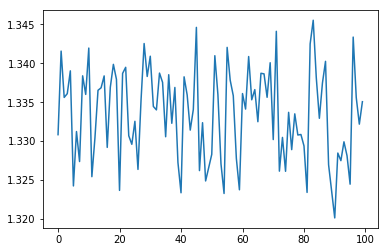

In [50]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline
plt.figure()
plt.plot(all_losses)

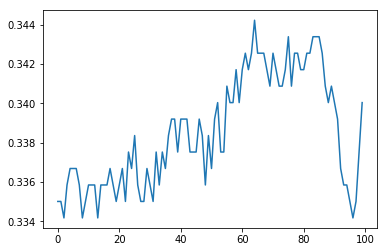

In [51]:
%matplotlib inline
plt.figure()
plt.plot(all_accuracy)

In [1]:
# Keep track of correct guesses in a confusion matrix
n_categories = 4
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = random_training_example()
    output = evaluate(line_tensor)
    guess, guess_i = category_from_output(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

NameError: name 'torch' is not defined